In [22]:
from importlib import reload
import numpy as np
from sklearn import cluster
import mido
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from '/storage/781-piano-autoencoder/src/ml_classes.py'>

In [3]:
files = [file for file in os.scandir('training_data/midi_val_8/')]
pm = pretty_midi.PrettyMIDI(files[np.random.randint(len(files))].path)
max_start = pm.instruments[0].notes[-1].start
notes = np.array([[note.start/ (2.5*max_start), note.pitch/127, (note.velocity - 21) / (127 * 1.5)] for note in pm.instruments[0].notes])

In [23]:
def divide_pm(pm, beats_per_ex=8, sub_beats = 2):
    """returns a list of lists of notes, divided into examples"""
    beat_length = pm.get_beats()[1]
    sub_beat_length = beat_length / sub_beats
    sub_beats_per_ex = sub_beats * beats_per_ex
    n_examples = len(pm.get_beats()) // beats_per_ex + 2
    example = 0
    examples = [[] for _ in range(n_examples)]
    for note in pm.instruments[0].notes:
        # if the note start falls after the start time of the next example, example index += 1
        if note.start > pm.get_beats()[example * beats_per_ex] + pm.get_beats()[1] / sub_beats * (beats_per_ex * sub_beats - 1):
            example += 1
        examples[example].append(note)
    return examples
    

In [24]:
# get some random examples for plotting
examples = []
for file in tqdm(files):
    pm = pretty_midi.PrettyMIDI(files[np.random.randint(len(files))].path)
    f_examples = divide_pm(pm)
    examples.append(f_examples[np.random.randint(len(f_examples))])
    

100%|██████████| 12/12 [00:58<00:00,  4.91s/it]


In [198]:
kmeans = cluster.KMeans(n_clusters=2).fit(notes)
spectral = cluster.SpectralClustering(n_clusters=2).fit(notes)
ag = cluster.AgglomerativeClustering(2)....fit(notes)

In [31]:
len(examples[4])

18

3.4822916666666686
3.5712500000000205
4.2099999999999795
2.764206848958338
3.648750000000007
4.466250000000002
4.493125000000006
4.194999999999993
3.855116848958332
4.163124999999999
4.169375000000002
2.3912499999999994


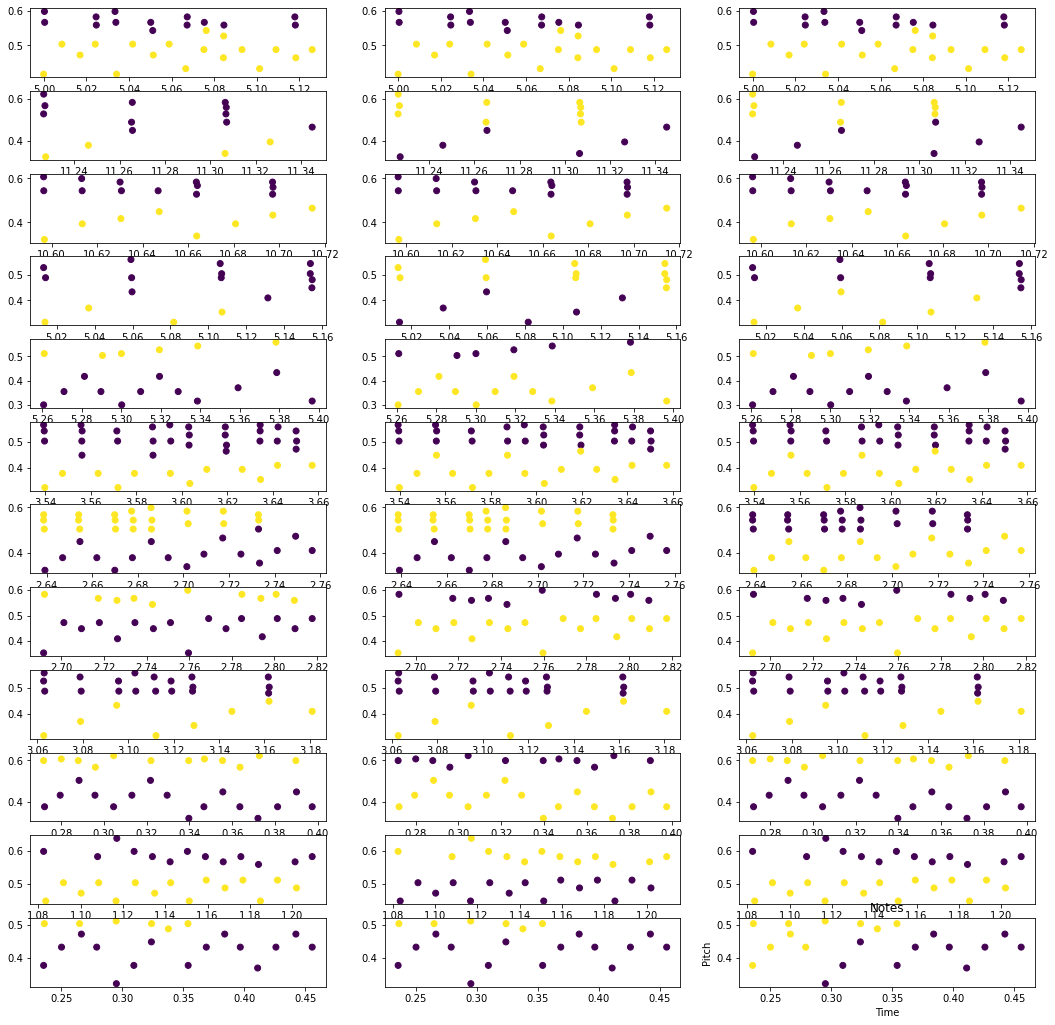

In [38]:
fig, ax = plt.subplots(nrows=len(examples),ncols=3, figsize=(18,18))
# plt.yscale('log')
for i, ex in enumerate(examples):
    duration = ex[-1].start - ex[0].start
    print(duration)
    notes = np.array([[note.start / (8.5*duration), note.pitch/127, (note.velocity - 21) / (127 * 2.5)] for note in ex])
    
    kmeans = cluster.KMeans(n_clusters=2).fit(notes)
    spectral = cluster.SpectralClustering(n_clusters=2).fit(notes)
    ag = cluster.AgglomerativeClustering(2).fit(notes)
    
    ax[i,0].scatter([n[0] for n in notes], [n[1] for n in notes], c=ag.labels_)
    ax[i,1].scatter([n[0] for n in notes], [n[1] for n in notes], c=kmeans.labels_)
    ax[i,2].scatter([n[0] for n in notes], [n[1] for n in notes], c=spectral.labels_)
    plt.title('Notes')
    plt.xlabel('Time')
    plt.ylabel('Pitch')

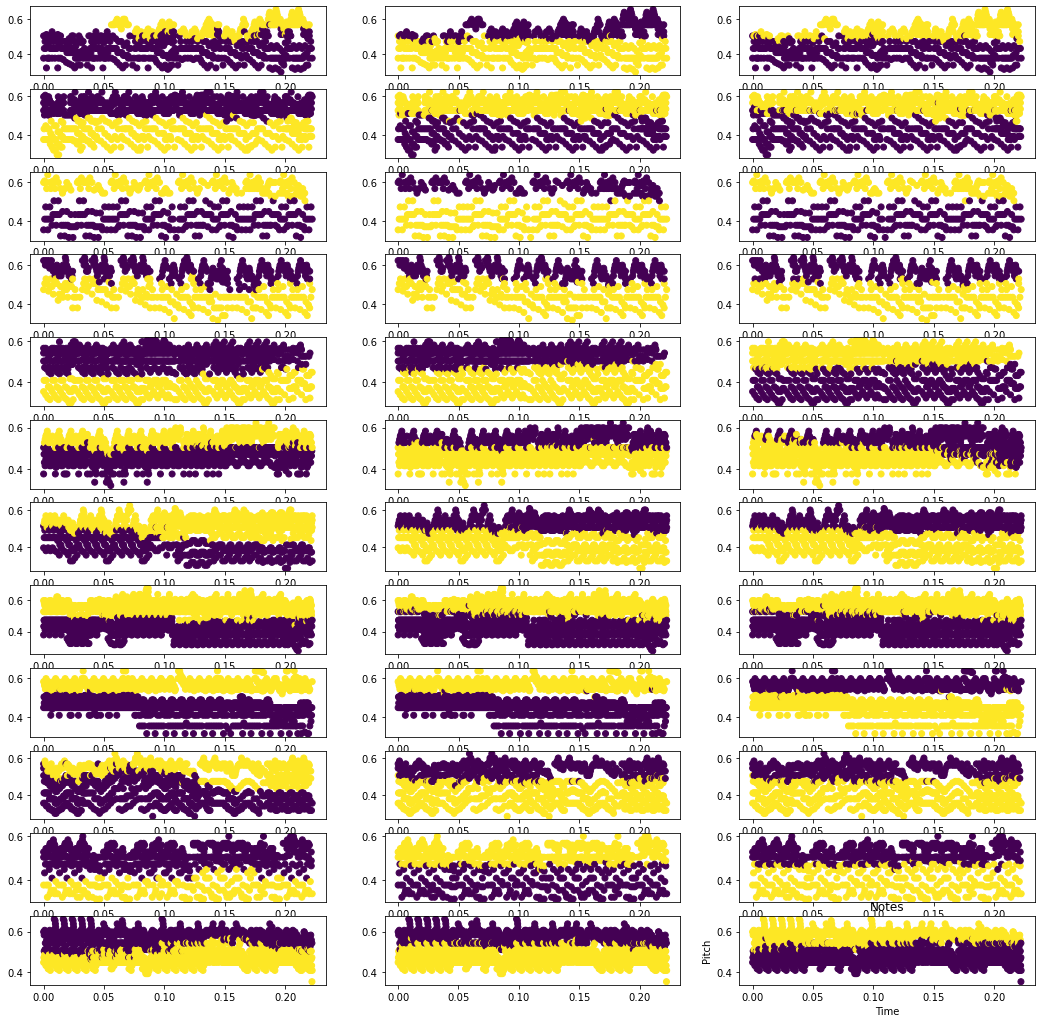

In [4]:
fig, ax = plt.subplots(nrows=len(files),ncols=3, figsize=(18,18))
# plt.yscale('log')
for i in range(len(files)):
    pm = pretty_midi.PrettyMIDI(files[i].path)
    max_start = pm.instruments[0].notes[-1].start
    notes = np.array([[note.start / (4.5*max_start), note.pitch/127, (note.velocity - 21) / (127 * 2.5)] for note in pm.instruments[0].notes])
    
    kmeans = cluster.KMeans(n_clusters=2).fit(notes)
    spectral = cluster.SpectralClustering(n_clusters=2).fit(notes)
    ag = cluster.AgglomerativeClustering(2).fit(notes)
    
    ax[i,0].scatter([n[0] for n in notes], [n[1] for n in notes], c=ag.labels_)
    ax[i,1].scatter([n[0] for n in notes], [n[1] for n in notes], c=kmeans.labels_)
    ax[i,2].scatter([n[0] for n in notes], [n[1] for n in notes], c=spectral.labels_)
    plt.title('Notes')
    plt.xlabel('Time')
    plt.ylabel('Pitch')

(array([ 1.,  0.,  0.,  0.,  2.,  6.,  7., 12., 18., 24., 26., 35., 52.,
        58., 31., 47., 22., 39., 23., 18., 27., 16., 15., 10., 22., 20.,
        31., 12., 21.,  5., 18., 10.,  5., 16.,  4., 10.,  5.,  1.,  5.,
         1.]),
 array([-0.20454545, -0.18011364, -0.15568182, -0.13125   , -0.10681818,
        -0.08238636, -0.05795455, -0.03352273, -0.00909091,  0.01534091,
         0.03977273,  0.06420455,  0.08863636,  0.11306818,  0.1375    ,
         0.16193182,  0.18636364,  0.21079545,  0.23522727,  0.25965909,
         0.28409091,  0.30852273,  0.33295455,  0.35738636,  0.38181818,
         0.40625   ,  0.43068182,  0.45511364,  0.47954545,  0.50397727,
         0.52840909,  0.55284091,  0.57727273,  0.60170455,  0.62613636,
         0.65056818,  0.675     ,  0.69943182,  0.72386364,  0.74829545,
         0.77272727]),
 <a list of 40 Patch objects>)

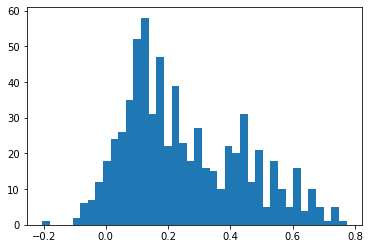

In [23]:
plt.hist([n[2] for n in notes], bins=20)